# Portfolio optimization via reinforcement learning

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import glob, os, os.path
import random
from google.colab import files
from zipfile import ZipFile
import seaborn as sns
from scipy.stats import kurtosis, skew


In [0]:
file_name = "important_data_new.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [0]:
uploaded = files.upload()

In [0]:
!rm -rf sample_data

## Semi-recurent neural network for portfolio optimization via reinforcement learning

## Srnn with variance

In [0]:
'''
Semi-recurent neural network for portfolio optimization via reinforcement learning (normal variance)
'''

import numpy as np
import tensorflow as tf
import glob, os, os.path
import random


## Class for initialization and construction of the neural network

class SRNN_portfolio_optimization(object):
    
    '''
    description
    '''
    
    def __init__(self, batch_size, num_inputs, time_steps, num_stocks, layers = [100, 50], learning_rate = 0.005, name = "model", srnn = True, restoreGraph = False):
        
        self.batch_size = batch_size
        self.num_inputs = num_inputs
        self.time_steps = time_steps
        self.num_stocks = num_stocks
        self.layers = layers
        self.learning_rate = learning_rate
        self.srnn = srnn
        
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        
        if restoreGraph is False :

            self.build()

            self.sess.run(tf.global_variables_initializer())
            #self.saver = tf.train.Saver()
            #self.saver.save(self.sess, 'save/my_test_model', global_step=1000, write_meta_graph=True)
            #self.writer = tf.summary.FileWriter('save/my_test_model', graph=tf.get_default_graph())
        
        else :
            
            tf.reset_default_graph()
            imported_meta = tf.train.import_meta_graph('save/my_test_model')
            imported_meta.restore(self.sess, tf.train.latest_checkpoint('./save'))
            
        return
    

    def build(self):
        
        self.inputs = tf.placeholder(tf.float32, [None, self.num_inputs, self.time_steps], name = "Inputs")
        self.Portfolio_value_init = tf.placeholder(tf.float32, [None], name = "P0")
        self.alpha = tf.placeholder(tf.float32, shape=(), name = "Alpha")
        self.lambda0 = tf.placeholder(tf.float32, shape=(), name = "Lambda")
        self.delta_init = tf.placeholder(tf.float32, [None, self.num_stocks], name = "DeltaInit")
        self.epsilon = tf.placeholder(tf.float32, shape=(), name = "Epsilon")
        self.c = tf.placeholder(tf.float32, shape=(), name = "Non_risk_cost")
        self.S = tf.math.exp(self.inputs[: , :self.num_stocks , :])
        self.dS = self.S[:, :, 1:] - self.S[:, :, 0:-1]
        self.delta_vect = [self.delta_init]
        self.Portfolio_value_vect = [self.Portfolio_value_init]
        self.cost_vect = []
        self.delta = self.delta_init
        self.proportions_vect = []
        self.returns_vect = []
            
        for iDate in range(self.time_steps-1):

            subInput = tf.concat([self.inputs[:, 1:, iDate], self.delta] , axis=1)
                
            for iLayer in self.layers :
                    
                fi = tf.contrib.layers.fully_connected(subInput, iLayer, activation_fn = tf.nn.relu, normalizer_fn = None) # put tf.contrib.layers.batch_norm if the data is no normalized
                subInput = fi
                
            self.proportions = tf.contrib.layers.fully_connected(subInput, self.num_stocks, activation_fn = tf.nn.softmax, normalizer_fn = None)
         
            self.proportions_leverage = tf.scalar_mul(1 + 2*self.lambda0, self.proportions) - self.lambda0
            
            self.delta = []
        
            for k in range(self.num_stocks):
           
                self.delta.append(tf.multiply(self.Portfolio_value_vect[iDate], tf.divide(self.proportions_leverage[:, k], self.S[:,k,iDate])))
        
            self.delta = tf.stack(self.delta, axis=-1)
          
            self.proportions_vect.append(self.proportions_leverage)
                
            self.delta_vect.append(self.delta)
            
            self.cost = self.epsilon * tf.diag_part(tf.tensordot(self.S[:,1:,iDate], tf.abs(self.delta_vect[iDate+1][:,1:] - self.delta_vect[iDate][:,1:]) , axes=[[1],[1]])) + self.c * tf.multiply(self.S[:,0,iDate], tf.abs(self.delta_vect[iDate+1][:,0] - self.delta_vect[iDate][:,0]))
            
            self.Portfolio_value = self.Portfolio_value_vect[iDate] + tf.diag_part(tf.tensordot(self.delta_vect[iDate+1], self.dS[:,:,iDate] , axes=[[1],[1]])) - self.cost
            
            self.cost_vect.append(self.cost)
            
            self.Portfolio_value_vect.append(self.Portfolio_value)
            
            self.returns = tf.divide(self.Portfolio_value_vect[iDate+1] - self.Portfolio_value_vect[iDate], self.Portfolio_value_vect[iDate])
            
            self.returns_vect.append(self.returns)
                
        self.proportions = tf.stack(self.proportions_vect, axis=-1)
        self.delta_vect = self.delta_vect[1:]
        self.deltas = tf.stack(self.delta_vect, axis=-1)
        self.Portfolio_values = tf.stack(self.Portfolio_value_vect, axis=-1)
        self.costs = tf.stack(self.cost_vect, axis=-1)
        self.returns = tf.stack(self.returns_vect, axis=-1)
        
        
        mean, var = tf.nn.moments(self.returns, axes=-1)
        self.objective_sample = self.alpha * var - mean
        self.objective = tf.reduce_mean(self.objective_sample)
        self.train = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.objective)
        
        return
    
    def run_single_step_train(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
        
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        _, objective = self.sess.run([self.train, self.objective], feed_dict = feed_dict)

        return objective
    
    def run_single_step_predict(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
            
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        Portfolio_values, deltas, proportions, returns = self.sess.run([self.Portfolio_values, self.deltas, self.proportions, self.returns], feed_dict = feed_dict)

        return Portfolio_values, deltas, proportions, returns
      
    def run_single_step_validation(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
            
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        objective = self.sess.run(self.objective, feed_dict = feed_dict)
        return objective
    

def train(inputs, inputs_validation, num_stocks, Portfolio_value_init, Portfolio_value_init_validation, delta_init, delta_init_validation, num_epoch, alpha = 5., lambda0 = 0., epsilon = 0., c = 0., layers = [100,50], learning_rate = 0.005, batch_size = 50, srnn = True,  restoreGraph = False ) :

    #random.seed(0)

    if restoreGraph is False :

        #np.random.seed(0)

        '''
        filelist = glob.glob(os.path.join(os.path.realpath(__file__), "save"))
        for f in filelist:
            os.remove(f)
        '''

        portfolio_train = SRNN_portfolio_optimization(batch_size, np.shape(inputs)[1], np.shape(inputs)[2], num_stocks, layers = layers, learning_rate = learning_rate, srnn = srnn, restoreGraph = restoreGraph )

        objectives = []

        for epoch in range(num_epoch):
          
            

            inputIndex = np.random.randint(0, np.shape(inputs)[0]-1, size = batch_size)

            inputs_batch = inputs[inputIndex[:], :, : ]

            objective = portfolio_train.run_single_step_train(inputs_batch, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c)

            objective_validation =  portfolio_train.run_single_step_validation(inputs_validation, Portfolio_value_init_validation, alpha, lambda0, delta_init_validation, epsilon, c)
            
            objectives.append(objective_validation)
            
            if epoch % 100 == 0:
              print(epoch)
              print(objective_validation)
            
    return portfolio_train, np.array(objectives)


def predict(portfolio_train, inputs, Portfolio_value_init, delta_init, alpha = 5., lambda0 = 0., epsilon = 0., c = 0.) :
  
    Portfolio_values, deltas, proportions, returns = portfolio_train.run_single_step_predict(inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c)
                 
    return np.array(Portfolio_values), np.array(deltas), np.array(proportions), np.array(returns)


  


## Srnn with semivariance

In [0]:
'''
Semi-recurent neural network for portfolio optimization via reinforcement learning (semivariance)
'''

import numpy as np
import tensorflow as tf
import glob, os, os.path
import random


## Class for initialization and construction of the neural network

class SRNN_portfolio_optimization(object):
    
    '''
    description
    '''
    
    def __init__(self, batch_size, num_inputs, time_steps, num_stocks, layers = [100, 50], learning_rate = 0.005, name = "model", srnn = True, restoreGraph = False):
        
        self.batch_size = batch_size
        self.num_inputs = num_inputs
        self.time_steps = time_steps
        self.num_stocks = num_stocks
        self.layers = layers
        self.learning_rate = learning_rate
        self.srnn = srnn
        
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        
        if restoreGraph is False :

            self.build()

            self.sess.run(tf.global_variables_initializer())
            #self.saver = tf.train.Saver()
            #self.saver.save(self.sess, 'save/my_test_model', global_step=1000, write_meta_graph=True)
            #self.writer = tf.summary.FileWriter('save/my_test_model', graph=tf.get_default_graph())
        
        else :
            
            tf.reset_default_graph()
            imported_meta = tf.train.import_meta_graph('save/my_test_model')
            imported_meta.restore(self.sess, tf.train.latest_checkpoint('./save'))
            
        return
    

    def build(self):
        
        self.inputs = tf.placeholder(tf.float32, [None, self.num_inputs, self.time_steps], name = "Inputs")
        self.Portfolio_value_init = tf.placeholder(tf.float32, [None], name = "P0")
        self.alpha = tf.placeholder(tf.float32, shape=(), name = "Alpha")
        self.lambda0 = tf.placeholder(tf.float32, shape=(), name = "Lambda")
        self.delta_init = tf.placeholder(tf.float32, [None, self.num_stocks], name = "DeltaInit")
        self.epsilon = tf.placeholder(tf.float32, shape=(), name = "Epsilon")
        self.c = tf.placeholder(tf.float32, shape=(), name = "Non_risk_cost")
        self.S = tf.math.exp(self.inputs[: , :self.num_stocks , :])
        self.dS = self.S[:, :, 1:] - self.S[:, :, 0:-1]
        self.delta_vect = [self.delta_init]
        self.Portfolio_value_vect = [self.Portfolio_value_init]
        self.cost_vect = []
        self.delta = self.delta_init
        self.proportions_vect = []
        self.returns_vect = []
            
        for iDate in range(self.time_steps-1):

            subInput = tf.concat([self.inputs[:, 1:, iDate], self.delta] , axis=1)
                
            for iLayer in self.layers :
                    
                fi = tf.contrib.layers.fully_connected(subInput, iLayer, activation_fn = tf.nn.relu, normalizer_fn = None) # put tf.contrib.layers.batch_norm if the data is no normalized
                subInput = fi
                
            self.proportions = tf.contrib.layers.fully_connected(subInput, self.num_stocks, activation_fn = tf.nn.softmax, normalizer_fn = None)
         
            self.proportions_leverage = tf.scalar_mul(1 + 2*self.lambda0, self.proportions) - self.lambda0
            
            self.delta = []
        
            for k in range(self.num_stocks):
           
                self.delta.append(tf.multiply(self.Portfolio_value_vect[iDate], tf.divide(self.proportions_leverage[:, k], self.S[:,k,iDate])))
        
            self.delta = tf.stack(self.delta, axis=-1)
          
            self.proportions_vect.append(self.proportions_leverage)
                
            self.delta_vect.append(self.delta)
            
            self.cost = self.epsilon * tf.diag_part(tf.tensordot(self.S[:,1:,iDate], tf.abs(self.delta_vect[iDate+1][:,1:] - self.delta_vect[iDate][:,1:]) , axes=[[1],[1]])) + self.c * tf.multiply(self.S[:,0,iDate], tf.abs(self.delta_vect[iDate+1][:,0] - self.delta_vect[iDate][:,0]))
            
            self.Portfolio_value = self.Portfolio_value_vect[iDate] + tf.diag_part(tf.tensordot(self.delta_vect[iDate+1], self.dS[:,:,iDate] , axes=[[1],[1]])) - self.cost
            
            self.cost_vect.append(self.cost)
            
            self.Portfolio_value_vect.append(self.Portfolio_value)
            
            self.returns = tf.divide(self.Portfolio_value_vect[iDate+1] - self.Portfolio_value_vect[iDate], self.Portfolio_value_vect[iDate])
            
            self.returns_vect.append(self.returns)
                
        self.proportions = tf.stack(self.proportions_vect, axis=-1)
        self.delta_vect = self.delta_vect[1:]
        self.deltas = tf.stack(self.delta_vect, axis=-1)
        self.Portfolio_values = tf.stack(self.Portfolio_value_vect, axis=-1)
        self.costs = tf.stack(self.cost_vect, axis=-1)
        self.returns = tf.stack(self.returns_vect, axis=-1)
        
        
        mean, var = tf.nn.moments(self.returns, axes=-1)
        
        centered_returns_list = []
        for k in range(self.time_steps-1):
          centered_return = tf.square(tf.maximum(mean - self.returns_vect[k],0.))
          centered_returns_list.append(centered_return)
          
        centered_returns = tf.stack(centered_returns_list, axis=-1)
        
        bad_variance = tf.reduce_mean(centered_returns, axis = -1)
        
        self.objective_sample = self.alpha * bad_variance - mean
        self.objective = tf.reduce_mean(self.objective_sample)
        self.train = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.objective)
        
        return
    
    def run_single_step_train(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
        
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        _, objective = self.sess.run([self.train, self.objective], feed_dict = feed_dict)

        return objective
    
    def run_single_step_predict(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
            
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        Portfolio_values, deltas, proportions, returns = self.sess.run([self.Portfolio_values, self.deltas, self.proportions, self.returns], feed_dict = feed_dict)

        return Portfolio_values, deltas, proportions, returns
    

def train(inputs, num_stocks, Portfolio_value_init, delta_init, num_epoch, alpha = 5., lambda0 = 0., epsilon = 0., c = 0., layers = [100,50], learning_rate = 0.005, batch_size = 50, srnn = True,  restoreGraph = False ) :

    #random.seed(0)

    if restoreGraph is False :

        #np.random.seed(0)

        '''
        filelist = glob.glob(os.path.join(os.path.realpath(__file__), "save"))
        for f in filelist:
            os.remove(f)
        '''

        portfolio_train = SRNN_portfolio_optimization(batch_size, np.shape(inputs)[1], np.shape(inputs)[2], num_stocks, layers = layers, learning_rate = learning_rate, srnn = srnn, restoreGraph = restoreGraph )

        objectives = []

        for epoch in range(num_epoch):
          
            if epoch % 100 == 0:
              print(epoch)

            inputIndex = np.random.randint(0, np.shape(inputs)[0]-1, size = batch_size)

            inputs_batch = inputs[inputIndex[:], :, : ]

            objective = portfolio_train.run_single_step_train(inputs_batch, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c)

            objectives.append(objective)
            
    return portfolio_train, np.array(objectives)


def predict(portfolio_train, inputs, Portfolio_value_init, delta_init, alpha = 5., lambda0 = 0., epsilon = 0., c = 0.) :
  
    Portfolio_values, deltas, proportions, returns = portfolio_train.run_single_step_predict(inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c)
                 
    return np.array(Portfolio_values), np.array(deltas), np.array(proportions), np.array(returns)


  


## LSTM

In [0]:
def mean_variance(alpha, returns):
  mean, var = tf.nn.moments(returns, axes=-1)
  return (1-alpha)* var - alpha * mean

In [0]:
'''
Semi-recurent neural network for portfolio optimization via reinforcement learning (normal variance)
'''

import numpy as np
import tensorflow as tf
import glob, os, os.path
import random


## Class for initialization and construction of the neural network

class SRNN_portfolio_optimization(object):
    
    '''
    description
    '''
    
    def __init__(self, batch_size, num_inputs, time_steps, num_stocks, loss = mean_variance,layers = [100, 50], learning_rate = 0.005, name = "model", srnn = True, restoreGraph = False):
        
        self.batch_size = batch_size
        self.num_inputs = num_inputs
        self.time_steps = time_steps
        self.num_stocks = num_stocks
        self.layers = layers
        self.learning_rate = learning_rate
        self.srnn = srnn
        self.loss=loss
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        
        if restoreGraph is False :

            self.build()

            self.sess.run(tf.global_variables_initializer())
            self.saver = tf.train.Saver()
            #self.saver.save(self.sess, 'save/my_test_model', global_step=1000, write_meta_graph=True)
        
        else :
            
            tf.train.Saver().restore(self.sess,'save/my_test_model')
            
        return
    

    def build(self):
        
        self.inputs = tf.placeholder(tf.float32, [None, self.num_inputs, self.time_steps], name = "Inputs")
        self.Portfolio_value_init = tf.placeholder(tf.float32, [None], name = "P0")
        self.alpha = tf.placeholder(tf.float32, shape=(), name = "Alpha")
        self.lambda0 = tf.placeholder(tf.float32, shape=(), name = "Lambda")
        self.delta_init = tf.placeholder(tf.float32, [None, self.num_stocks], name = "DeltaInit")
        self.epsilon = tf.placeholder(tf.float32, shape=(), name = "Epsilon")
        self.c = tf.placeholder(tf.float32, shape=(), name = "Non_risk_cost")
        self.S = tf.math.exp(self.inputs[: , :self.num_stocks , :])
        self.dS = self.S[:, :, 1:] - self.S[:, :, 0:-1]
        self.delta_vect = [self.delta_init]
        self.Portfolio_value_vect = [self.Portfolio_value_init]
        self.cost_vect = []
        self.delta = self.delta_init
        self.proportions_vect = []
        self.returns_vect = []
        
        '''
        for iDate in range(self.time_steps-1):

            subInput = tf.concat([self.inputs[:, 1:, iDate], self.delta] , axis=1)
                
            for iLayer in self.layers :
                    
                fi = tf.contrib.layers.fully_connected(subInput, iLayer, activation_fn = tf.nn.relu, normalizer_fn = None) # put tf.contrib.layers.batch_norm if the data is no normalized
                subInput = fi
                
            self.proportions = tf.contrib.layers.fully_connected(subInput, self.num_stocks, activation_fn = tf.nn.softmax, normalizer_fn = None)
         
            self.proportions_leverage = tf.scalar_mul(1 + 2*self.lambda0, self.proportions) - self.lambda0
        '''
        self.inputs_lstm = tf.transpose(self.inputs, perm = [0,2,1])
        
        self.cell = [tf.nn.rnn_cell.LSTMCell(num_units=n, num_proj = self.num_stocks) for n in self.layers]
        #tf.nn.rnn_cell.LSTMCell(num_units=200, num_proj = self.num_stocks)
        self.multi_cell = tf.nn.rnn_cell.MultiRNNCell(self.cell)
        self.cell_wrapped = tf.contrib.rnn.OutputProjectionWrapper(self.multi_cell, self.num_stocks, activation = tf.nn.softmax)
        self.proportions, self.states = tf.nn.dynamic_rnn(self.cell_wrapped, self.inputs_lstm, dtype=tf.float32)
            
        self.proportions = tf.transpose(self.proportions, perm = [0,2,1])
        
        for iDate in range(self.time_steps-1):
            self.delta = []
            for k in range(self.num_stocks):
           
                self.delta.append(tf.multiply(self.Portfolio_value_vect[iDate], tf.divide(self.proportions[:, k, iDate], self.S[:,k,iDate])))
        
            self.delta = tf.stack(self.delta, axis=-1)
          
            #self.proportions_vect.append(self.proportions)
                
            self.delta_vect.append(self.delta)
            
            self.cost = self.epsilon * tf.diag_part(tf.tensordot(self.S[:,1:,iDate], tf.abs(self.delta_vect[iDate+1][:,1:] - self.delta_vect[iDate][:,1:]) , axes=[[1],[1]])) + self.c * tf.multiply(self.S[:,0,iDate], tf.abs(self.delta_vect[iDate+1][:,0] - self.delta_vect[iDate][:,0]))
            
            self.Portfolio_value = self.Portfolio_value_vect[iDate] + \
                                  tf.diag_part(tf.tensordot(self.delta_vect[iDate+1], 
                                                            self.dS[:,:,iDate] , axes=[[1],[1]])) - self.cost
            
            self.cost_vect.append(self.cost)
            
            self.Portfolio_value_vect.append(self.Portfolio_value)
            
            self.returns = tf.divide(self.Portfolio_value_vect[iDate+1] - self.Portfolio_value_vect[iDate], self.Portfolio_value_vect[iDate])
            
            self.returns_vect.append(self.returns)
                
        
        self.delta_vect = self.delta_vect[1:]
        self.deltas = tf.stack(self.delta_vect, axis=-1)
        self.Portfolio_values = tf.stack(self.Portfolio_value_vect, axis=-1)
        self.costs = tf.stack(self.cost_vect, axis=-1)
        self.returns = tf.stack(self.returns_vect, axis=-1)
        
        
        self.objective_sample = self.loss(self.alpha, self.returns)
        self.objective = tf.reduce_mean(self.objective_sample)
        self.train = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.objective)
        
        return
    
    def run_single_step_train(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
        
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        _, objective = self.sess.run([self.train, self.objective], feed_dict = feed_dict)

        return objective
    
    def run_single_step_predict(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
            
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        Portfolio_values, deltas, proportions, returns = self.sess.run([self.Portfolio_values, self.deltas, self.proportions, self.returns], feed_dict = feed_dict)

        return Portfolio_values, deltas, proportions, returns
      
    def run_single_step_validation(self, inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c):
            
        feed_dict = {self.inputs : inputs, self.Portfolio_value_init : Portfolio_value_init, self.alpha : alpha, self.lambda0 : lambda0, self.delta_init : delta_init, self.epsilon : epsilon, self.c : c}
        objective = self.sess.run(self.objective, feed_dict = feed_dict)
        return objective
    

def train(inputs, inputs_validation, num_stocks, Portfolio_value_init, Portfolio_value_init_validation, delta_init, delta_init_validation, num_epoch, alpha = 5., lambda0 = 0., epsilon = 0., c = 0., layers = [100,50], learning_rate = 0.005, batch_size = 50, srnn = True,  restoreGraph = False ) :

    #random.seed(0)

    if restoreGraph is False :

        #np.random.seed(0)

        '''
        filelist = glob.glob(os.path.join(os.path.realpath(__file__), "save"))
        for f in filelist:
            os.remove(f)
        '''

        portfolio_train = SRNN_portfolio_optimization(batch_size, np.shape(inputs)[1], np.shape(inputs)[2], num_stocks, layers = layers, learning_rate = learning_rate, srnn = srnn, restoreGraph = restoreGraph )

        objectives = []
        
        objective_validation_min = np.infty

        for epoch in range(num_epoch):
          
            

            inputIndex = np.random.randint(0, np.shape(inputs)[0]-1, size = batch_size)

            inputs_batch = inputs[inputIndex[:], :, : ]

            objective = portfolio_train.run_single_step_train(inputs_batch, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c)

            objective_validation =  portfolio_train.run_single_step_validation(inputs_validation, Portfolio_value_init_validation, alpha, lambda0, delta_init_validation, epsilon, c)
            
            objectives.append(objective_validation)
            
            if epoch % 10 == 0:
              print(epoch)
              print(objective_validation)
              
              if objective_validation <= objective_validation_min:
                portfolio_train.saver.save(portfolio_train.sess, 'save/my_test_model')
    portfolio_train.sess.close()
    return portfolio_train, np.array(objectives)


def predict(inputs, num_stocks, Portfolio_value_init, delta_init, alpha = 5., lambda0 = 0., epsilon = 0., c = 0., layers = [100,50], learning_rate = 0.005, batch_size = 50, srnn = True,  restoreGraph = True ) :
  
    portfolio_train = SRNN_portfolio_optimization(batch_size, np.shape(inputs)[1], np.shape(inputs)[2], num_stocks=num_stocks, layers = layers, learning_rate = learning_rate, srnn = srnn, restoreGraph = restoreGraph )
    
  
    Portfolio_values, deltas, proportions, returns = portfolio_train.run_single_step_predict(inputs, Portfolio_value_init, alpha, lambda0, delta_init, epsilon, c)
                 
    return np.array(Portfolio_values), np.array(deltas), np.array(proportions), np.array(returns)


  


## Numerical results

### Toy model

Train

In [0]:
num_assets = 3
batch_size = 50
alpha = 5.
layers = [80, 40]
learning_rate = 10**(-4)
Portfolio_value_init = np.ones(batch_size)*100
delta_init = np.zeros([batch_size, num_assets])
num_epoch = 1000


cash = np.ones([1000,31])

list_S1 = []
list_S2 = []
for i in range(1000):
    y = np.array(range(100, 131))
    z = np.array(range(130, 99, -1))
    list_S1.append(np.log(y))
    list_S2.append(np.log(z))
    
inputs = np.array([cash, list_S1, list_S2])
inputs = np.transpose(inputs, (1,0,2))



In [0]:
portfolio_train, objectives_train = train(inputs, num_assets, Portfolio_value_init, delta_init, num_epoch, batch_size = batch_size,
                                         alpha = alpha, layers = layers, learning_rate = learning_rate)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0
100
200
300
400
500
600
700
800
900


Test

In [0]:
cash = np.ones([1,31])

list_S1_test = []
list_S2_test = []
for i in range(1):
    y = np.array(range(100, 131))
    z = np.array(range(130, 99, -1))
    list_S1_test.append(np.log(y))
    list_S2_test.append(np.log(z))
    
inputs_test = np.array([cash, list_S1_test, list_S2_test])
inputs_test = np.transpose(inputs_test, (1,0,2))

Portfolio_value_init_test = np.ones(1)*100
delta_init_test = np.zeros([1, num_assets])

In [0]:
Portfolio_values_test, deltas_vect_test, proportions_vect_test, returns_vect_test = predict(portfolio_train, inputs_test, Portfolio_value_init_test, delta_init_test)

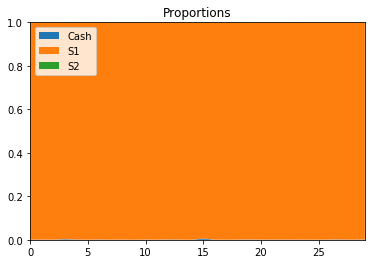

In [0]:
plt.stackplot(range(30), proportions_vect_test[0,0,:], proportions_vect_test[0,1,:], proportions_vect_test[0,2,:], labels=['Cash','S1','S2'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Proportions')
plt.show()


### No transaction costs

Train


In [40]:
inputs_train = np.load('important_data_new/inputs_train_normalized.npy')
inputs_train.shape

(8190, 79, 91)

In [0]:
num_assets = 14
batch_size = 50
alpha = 0.5
layers = [100, 50, 50]
learning_rate = 10**(-4)
Portfolio_value_init = np.ones(batch_size)*100
delta_init = np.zeros([batch_size, num_assets])
num_epoch = 20

In [42]:
inputs_val_test = np.load('important_data_new/inputs_test_normalized.npy')
inputs_val_test.shape

(23, 79, 91)

In [0]:
inputs_validation = inputs_val_test[:10,:,:]

In [0]:
Portfolio_value_init_validation = np.ones(10)*100
delta_init_validation = np.zeros([10, num_assets])


In [48]:
portfolio_train, objectives_train = train(inputs_train, inputs_validation, num_assets, Portfolio_value_init, Portfolio_value_init_validation,
                                          delta_init, delta_init_validation, num_epoch, batch_size = batch_size, learning_rate = learning_rate, layers = layers, alpha = alpha)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0
-0.00015406343
10
-0.00015377619


In [0]:
print(objectives_train[:50])
print(objectives_train[-50:])

[-3.02236236e-04  2.24468589e-04  7.04864578e-05  1.41990618e-04
  5.31200960e-04  2.34743697e-04 -2.77145329e-04 -2.79873755e-04
  2.34463805e-04 -2.26189179e-04  6.72966591e-04 -3.44886561e-04
 -9.78688695e-05  2.74431222e-04  1.10390101e-04 -2.72202422e-04
  3.08098446e-04  4.56179987e-05 -7.80791306e-05 -6.42015511e-05
  2.71007098e-04  1.82277203e-04  4.42104138e-05  2.95455713e-04
  2.82300374e-04  4.15237038e-04  7.38487097e-06  6.26629990e-05
  1.48176259e-04  1.77940150e-04  6.94028044e-04 -6.54307078e-05
  5.75153099e-05 -1.11090449e-04  6.75157411e-04 -5.40688925e-05
 -1.19713281e-04  6.94442060e-05 -2.66948162e-04 -1.10683504e-04
  4.38623218e-04 -1.60822645e-04 -2.45442843e-05  4.52277221e-04
  1.24171158e-04  2.11684557e-04 -3.11897689e-04  2.39628585e-04
  6.95791823e-05 -7.02692660e-06]
[-5.21737138e-06  1.70245316e-04 -4.36327537e-04 -3.55932832e-04
  1.46691571e-04 -5.30727266e-05  3.32660682e-04 -2.77782616e-04
 -3.16426391e-04 -4.83012009e-05  7.54374923e-05  3.1021

Test

In [49]:
inputs_val_test = np.load('important_data_new/inputs_test_normalized.npy')
inputs_val_test.shape

(23, 79, 91)

In [0]:
inputs_test = inputs_val_test[10:, :, :]

In [0]:
num_assets = 14
Portfolio_value_init_test = np.ones(1)*100
delta_init_test = np.zeros([1, num_assets])

In [55]:
Portfolio_values = []
deltas_vect = []
proportions_vect = []
returns_vect = []
for k in range(13):
  Portfolio_values_test, deltas_vect_test, proportions_vect_test, returns_vect_test = predict(np.expand_dims(inputs_test[k,:,:], 0), Portfolio_value_init_test, delta_init_test, alpha = alpha)
  Portfolio_values.append(Portfolio_values_test[0,1:])
  deltas_vect.append(deltas_vect_test[0,:,:])
  proportions_vect.append(proportions_vect_test[0,:,:])
  returns_vect.append(returns_vect_test[0,:])
  Portfolio_value_init_test = np.ones(1)*Portfolio_values_test[0,90]
  delta_init_test = np.expand_dims(deltas_vect_test[0,:,89],0)
  
  
Portfolio_values = np.array(Portfolio_values)
Portfolio_values_total = np.concatenate(Portfolio_values, axis=0)
Portfolio_values_total = np.append(100,Portfolio_values_total)

proportions_vect = np.array(proportions_vect)
proportions_vect = np.concatenate(proportions_vect, axis=1)

deltas_vect = np.array(deltas_vect)
deltas_vect = np.concatenate(deltas_vect, axis=1)

returns_vect = np.array(returns_vect)
returns_vect = np.concatenate(returns_vect, axis=0)
  

TypeError: ignored

In [95]:
proportions_vect.shape

(14, 1183)

In [0]:
ptf_cap_total = np.load("important_data_new/pft_cap_total.npy")
ptf_cap_total.shape
ptf_cap_total=ptf_cap_total[-1171:]

In [0]:
ptf_cap_total = ptf_cap_total/ptf_cap_total[0]*100

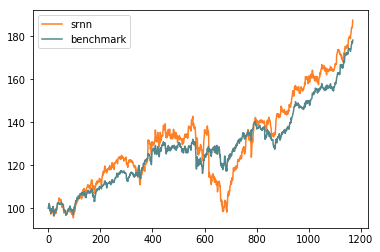

In [92]:
plt.plot(Portfolio_values_total, '#ff7f24', label = "srnn")
plt.plot(ptf_cap_total, '#53868b', label = "benchmark")
plt.legend(loc='upper left')

plt.savefig('portfolio_value_1.eps', format='eps', dpi=1000)

plt.show()

#files.download("portfolio_value_1.eps")


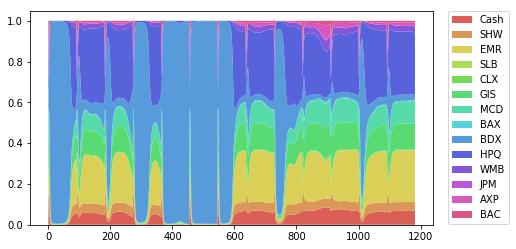

In [96]:
fig = plt.figure(figsize=(8,3.5))
ax  = fig.add_subplot(111)

labels = ["Cash", "SHW", "EMR", "SLB", "CLX", "GIS", "MCD", "BAX", "BDX", "HPQ", "WMB", "JPM", "AXP", "BAC"]
pal = sns.color_palette("hls", 14)
ax.set_position([0.1,0.1,0.7,0.85])
ax.stackplot(range(1183), proportions_vect[0,:], proportions_vect[1, :], proportions_vect[2, :], 
             proportions_vect[3, :], proportions_vect[4, :], proportions_vect[5, :],
             proportions_vect[6, :], proportions_vect[7, :], proportions_vect[8, :],
             proportions_vect[9, :], proportions_vect[10, :], proportions_vect[11, :],
             proportions_vect[12, :], proportions_vect[13, :],colors=pal, labels=labels)
#ax.legend(loc=10)

ax.legend(bbox_to_anchor=(1.20, 0.5), loc='right', ncol=1)


plt.savefig('proportions_1.eps', format='eps', dpi=1000)


plt.show()

#files.download("proportions_1.eps")


### Transaction costs

Train


In [6]:
inputs_train = np.load('important_data_new/inputs_train_normalized.npy')
inputs_train.shape

(8190, 79, 91)

In [0]:
num_assets = 14
batch_size = 50
alpha = 0.9
layers = [100, 50, 50]
epsilon = 0.00001
learning_rate = 10**(-4)
Portfolio_value_init = np.ones(batch_size)*100
delta_init = np.zeros([batch_size, num_assets])
num_epoch = 300

In [8]:
inputs_val_test = np.load('important_data_new/inputs_test_normalized.npy')
inputs_val_test.shape

(23, 79, 91)

In [0]:
inputs_validation = inputs_val_test[:10,:,:]

In [0]:
Portfolio_value_init_validation = np.ones(10)*100
delta_init_validation = np.zeros([10, num_assets])

In [31]:
portfolio_train, objectives_train = train(inputs_train,inputs_validation, num_assets, Portfolio_value_init, Portfolio_value_init_validation, 
                                          delta_init, delta_init_validation, num_epoch, batch_size = batch_size, learning_rate = learning_rate, layers = layers, 
                                          alpha = alpha, epsilon = epsilon)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0
-0.00036571297
100
-0.0004155161
200
-0.0006050622


In [0]:
print(objectives_train[:50])
print(objectives_train[-50:])

[0.00255656 0.00244122 0.0023906  0.00228568 0.00287814 0.00242654
 0.00305616 0.00206494 0.00200849 0.00225597 0.00254965 0.00201635
 0.00266121 0.00220674 0.00235726 0.00228411 0.00214707 0.00231969
 0.00212621 0.00202762 0.00235181 0.00230962 0.00207418 0.00208504
 0.00190819 0.00216769 0.00195144 0.00212114 0.0019426  0.00258585
 0.00208229 0.00214992 0.00209896 0.00210069 0.00216954 0.0021672
 0.00235005 0.00173403 0.00177208 0.00205329 0.00191048 0.00236599
 0.00209511 0.00194436 0.00190729 0.00220518 0.00222283 0.00216082
 0.00190339 0.00194444]
[0.00117529 0.00163354 0.00149232 0.00130002 0.00132764 0.00140438
 0.00128265 0.00120961 0.00181825 0.0015632  0.00142763 0.00163424
 0.00157671 0.00147505 0.00128773 0.0016656  0.00146872 0.00126853
 0.00140992 0.0015486  0.00141296 0.00107953 0.00153581 0.00172067
 0.0016694  0.00146596 0.00161099 0.00136485 0.00165376 0.0014102
 0.00127202 0.00153723 0.00147681 0.00157953 0.00144039 0.0013933
 0.00145487 0.00135226 0.00207043 0.00170

Test

In [13]:
inputs_val_test = np.load('important_data_new/inputs_test_normalized.npy')
inputs_val_test.shape

(23, 79, 91)

In [0]:
inputs_test = inputs_val_test[10:, :, :]

In [0]:
num_assets = 14
Portfolio_value_init_test = np.ones(1)*100
delta_init_test = np.zeros([1, num_assets])

In [0]:
Portfolio_values = []
deltas_vect = []
proportions_vect = []
returns_vect = []
for k in range(13):
  Portfolio_values_test, deltas_vect_test, proportions_vect_test, returns_vect_test = predict(portfolio_train, np.expand_dims(inputs_test[k,:,:], 0), Portfolio_value_init_test, delta_init_test, alpha = alpha, epsilon = epsilon)
  Portfolio_values.append(Portfolio_values_test[0,1:])
  deltas_vect.append(deltas_vect_test[0,:,:])
  proportions_vect.append(proportions_vect_test[0,:,:])
  returns_vect.append(returns_vect_test[0,:])
  Portfolio_value_init_test = np.ones(1)*Portfolio_values_test[0,90]
  delta_init_test = np.expand_dims(deltas_vect_test[0,:,89],0)
  
  
Portfolio_values = np.array(Portfolio_values)
Portfolio_values_total = np.concatenate(Portfolio_values, axis=0)
Portfolio_values_total = np.append(100,Portfolio_values_total)

proportions_vect = np.array(proportions_vect)
proportions_vect = np.concatenate(proportions_vect, axis=1)

deltas_vect = np.array(deltas_vect)
deltas_vect = np.concatenate(deltas_vect, axis=1)

returns_vect = np.array(returns_vect)
returns_vect = np.concatenate(returns_vect, axis=0)
  
  
  

In [18]:
Portfolio_values_total.shape

(1171,)

In [0]:
ptf_cap_total = np.load("important_data_new/pft_cap_total.npy")
ptf_cap_total.shape
ptf_cap_total=ptf_cap_total[-1171:]

In [0]:
ptf_cap_total = ptf_cap_total/ptf_cap_total[0]*100

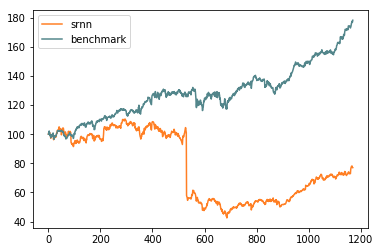

In [34]:
plt.plot(Portfolio_values_total, '#ff7f24', label = "srnn")
plt.plot(ptf_cap_total, '#53868b', label = "benchmark")
plt.legend(loc='upper left')

plt.savefig('portfolio_value_transactions_1.eps', format='eps', dpi=1000)

plt.show()

#files.download("portfolio_value_transactions_1.eps")

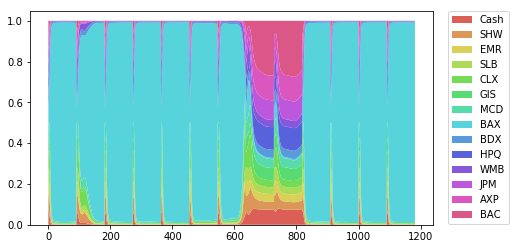

In [35]:
fig = plt.figure(figsize=(8,3.5))
ax  = fig.add_subplot(111)

labels = ["Cash", "SHW", "EMR", "SLB", "CLX", "GIS", "MCD", "BAX", "BDX", "HPQ", "WMB", "JPM", "AXP", "BAC"]
pal = sns.color_palette("hls", 14)
ax.set_position([0.1,0.1,0.7,0.85])
ax.stackplot(range(1183), proportions_vect[0,:], proportions_vect[1, :], proportions_vect[2, :], 
             proportions_vect[3, :], proportions_vect[4, :], proportions_vect[5, :],
             proportions_vect[6, :], proportions_vect[7, :], proportions_vect[8, :],
             proportions_vect[9, :], proportions_vect[10, :], proportions_vect[11, :],
             proportions_vect[12, :], proportions_vect[13, :],colors=pal, labels=labels)
#ax.legend(loc=10)

ax.legend(bbox_to_anchor=(1.20, 0.5), loc='right', ncol=1)


plt.savefig('proportions_transactions_1.eps', format='eps', dpi=1000)


plt.show()

#files.download("proportions_transactions_1.eps")


## Statistics for srnn

**Mean**

In [97]:
np.mean(returns_vect)

0.00059177773

**Volatility**

In [98]:
np.std(returns_vect)

0.010339642

**Skewness**

In [99]:
skew(returns_vect)

-2.6994845867156982

**Kurtosis (Fisher definition (-3))**

In [100]:
kurtosis(returns_vect)

39.74717689114416

**Turnover**

In [101]:
np.mean(np.sum(np.abs(proportions_vect[:,1:] - proportions_vect[:,:-1]), axis = 0))

0.041692264

**Maximum Drawdown**

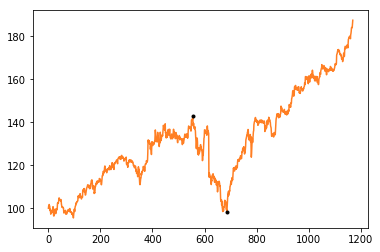

0.45409294785730625

In [102]:
i = np.argmax(np.maximum.accumulate(Portfolio_values_total) - Portfolio_values_total) # end of the period
j = np.argmax(Portfolio_values_total[:i])

plt.plot(Portfolio_values_total, '#ff7f24')
plt.plot([i, j], [Portfolio_values_total[i], Portfolio_values_total[j]], 'o', color = 'k', markersize = 3)

plt.show()

(Portfolio_values_total[j] - Portfolio_values_total[i])/Portfolio_values_total[i]


## Statistics for benchmark

In [0]:
returns_benchmark = (ptf_cap_total[1:] - ptf_cap_total[:-1]) / ptf_cap_total[:-1]

**Mean**

In [104]:
np.mean(returns_benchmark)

0.0005200717640137289

**Volatility**

In [0]:
np.std(returns_benchmark)

0.008354433179746603

**Skewness**

In [0]:
skew(returns_benchmark)

-0.3733724245957868

**Kurtosis (Fisher definition (-3))**

In [0]:
kurtosis(returns_benchmark)

3.3228092566869707

**Maximum Drawdown**

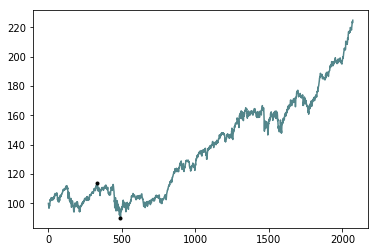

0.2638151063310318

In [0]:
i = np.argmax(np.maximum.accumulate(ptf_cap_total) - ptf_cap_total) # end of the period
j = np.argmax(ptf_cap_total[:i])

plt.plot(ptf_cap_total, '#53868b')
plt.plot([i, j], [ptf_cap_total[i], ptf_cap_total[j]], 'o', color = 'k', markersize = 3)

plt.show()

(ptf_cap_total[j] - ptf_cap_total[i])/ptf_cap_total[i]


## Information Ratio

In [105]:
np.sqrt(252)*(np.mean(returns_vect - returns_benchmark))/(np.std(returns_vect - returns_benchmark))

0.15971828379761524